In [31]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib


#change the default matplotlib font to CMU Serif
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['CMU Serif']

In [32]:
map_df = gpd.read_file(f"./Croatia shape map/pj868ps1513.shp")
# change entry 129 to Santa Domenica to avoid duplicates
map_df["name_2"][129] = "Santa Domenica"


C:\Users\Fran\AppData\Local\Temp\ipykernel_28632\2316807186.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  map_df["name_2"][129] = "Santa Domenica"
C:\Users\Fran\AppData\Local\Temp\ipykernel_28632\2316807186.py:3: SettingWithCopyWarning

In [47]:
import difflib

def vote_import(excel_file, party_name):
    #import vote data from excel
    votes = pd.read_excel(excel_file)
    # if the file name is "02_08", change city name "SVETA NEDELJA" to "SANTA DOMENICA":
    if "02_08" in excel_file:
        votes["Grad/općina/država"][votes["Grad/općina/država"] == "SVETA NEDELJA"] = "SANTA DOMENICA"

    # create a new dataframe only with the votes[votes.keys()[5]] and votes.keys()[i] for i in range(15, len(votes.keys()), 15)

    votes_df = pd.DataFrame()
    
    votes_df[votes.keys()[5]] = votes[votes.keys()[5]]
    for i in range(15, len(votes.keys()), 15):
        votes_df[votes.keys()[i]] = votes[votes.keys()[i]]
    #merge all entries with the same entry in votes_df["Grad/općina/država"] by adding up all the numbers in other columns
    votes_df = votes_df.groupby(votes_df[votes.keys()[5]]).sum()
    votes_df = votes_df.reset_index()
    #print the data frame as a nice table
    

    
    if party_name == "None":
        votes_df["winner_percentage"] = votes_df[votes_df.keys()[1:]].max(axis=1) / votes_df[votes_df.keys()[1:]].sum(axis=1)
        
        max_no = votes_df[votes_df.keys()[1:]].idxmax(axis=1)
        votes_no = votes_df[votes_df.keys()[1:]].sum(axis=1)
        
        votes_df["winner"] = max_no
        city_winner = pd.DataFrame()
        city_winner["City"] = votes_df[votes_df.keys()[0]]
        city_winner["winner"] = votes_df["winner"]
        city_winner["winner_percentage"] = votes_df["winner_percentage"]
        city_winner["total votes"] = votes_no
        return city_winner
    
    else:
        for i in votes_df.keys()[1:]:
            if party_name in i:
                votes_df["winner_percentage"] = votes_df[i] / votes_df[votes_df.keys()[1:]].sum(axis=1)
                votes_df["winner"] = i
                city_winner = pd.DataFrame()
                city_winner["City"] = votes_df[votes_df.keys()[0]]
                city_winner["winner"] = votes_df["winner"]
                city_winner["winner_percentage"] = votes_df["winner_percentage"]
                city_winner["no of votes"] = votes_df[i]

                return city_winner
        

In [43]:
def data_import_and_process(party_name, year):
    for i in range(1, 11):
        
        if i < 10: 
            city_winner = vote_import(f"./{year}/Results/02_0{str(i)}.xlsx", party_name)
        else:
            city_winner = vote_import(f"./{year}/Results/02_{str(i)}.xlsx", party_name)
        # combine the city_winner dataframes
        if i == 1:
            all_city_winner = city_winner
        else:
            all_city_winner = pd.concat([all_city_winner, city_winner])
    
    #reset the index
    all_city_winner = all_city_winner.reset_index()
    #remove the old index
    all_city_winner = all_city_winner.drop(columns=["index"])

    #turn the dataframe into a dictionary
    all_city_winner_dict = all_city_winner.T.to_numpy()

    #turn all all_city_winner_dict[0] lowerdase apart from the first letter
    for i in range(len(all_city_winner_dict[0])):
        all_city_winner_dict[0][i] = all_city_winner_dict[0][i].capitalize()
        
    # from each city name remove everything after " - " unless "Zagreb" is in the name

    for i in range(len(all_city_winner_dict[0])):
        if "Zagreb" not in all_city_winner_dict[0][i]:
            all_city_winner_dict[0][i] = all_city_winner_dict[0][i].split(" - ")[0]
            
            
    total_Zagreb_votes = 0
    party_votes = 0
    
    if party_name == "None":
        # find Zagreb winner SDP or HDZ
        for i in range(1, 11):
            
            if i < 10: 
                zagreb_winner_sdp = vote_import(f"./{year}/Results/02_0{str(i)}.xlsx", "SDP")
            else:
                zagreb_winner_sdp = vote_import(f"./{year}/Results/02_{str(i)}.xlsx", "SDP")
            # combine the city_winner dataframes
            if i == 1:
                all_zagreb_winner_sdp = zagreb_winner_sdp
            else:
                all_zagreb_winner_sdp = pd.concat([all_zagreb_winner_sdp, zagreb_winner_sdp])
                
                
        SDP_votes = 0
        for i in range(len(all_city_winner_dict[0])):
            if "Zagreb" in all_city_winner_dict[0][i]:
                total_Zagreb_votes += all_city_winner_dict[3][i]
                SDP_votes += all_city_winner_dict[2][i]*all_city_winner_dict[3][i]
                
        for i in range(1, 11):
                
                if i < 10: 
                    zagreb_winner_hdz = vote_import(f"./{year}/Results/02_0{str(i)}.xlsx", "HDZ")
                else:
                    zagreb_winner_hdz = vote_import(f"./{year}/Results/02_{str(i)}.xlsx", "HDZ")
                # combine the city_winner dataframes
                if i == 1:
                    all_zagreb_winner_hdz = zagreb_winner_hdz
                else:
                    all_zagreb_winner_hdz = pd.concat([all_zagreb_winner_hdz, zagreb_winner_hdz])
                    
        HDZ_votes = 0
        for i in range(len(all_city_winner_dict[0])):
            if "Zagreb" in all_city_winner_dict[0][i]:
                HDZ_votes += all_city_winner_dict[2][i]*all_city_winner_dict[3][i]
                
        if SDP_votes > HDZ_votes:
            for i in range(len(all_city_winner_dict[0])):
                if "Zagreb" in all_city_winner_dict[0][i]:
                    all_city_winner_dict[0][i] = "Zagreb"
                    all_city_winner_dict[1][i] = "SDP"
                    all_city_winner_dict[2][i] = SDP_votes / total_Zagreb_votes
                    all_city_winner_dict[3][i] = total_Zagreb_votes
        else:
            for i in range(len(all_city_winner_dict[0])):
                if "Zagreb" in all_city_winner_dict[0][i]:
                    all_city_winner_dict[0][i] = "Zagreb"
                    all_city_winner_dict[1][i] = "HDZ"
                    all_city_winner_dict[2][i] = HDZ_votes / total_Zagreb_votes
                    all_city_winner_dict[3][i] = total_Zagreb_votes
                
    else:
        for i in range(len(all_city_winner_dict[0])):
            if "Zagreb" in all_city_winner_dict[0][i]:
                total_Zagreb_votes += all_city_winner_dict[3][i]
                party_votes += all_city_winner_dict[2][i]*all_city_winner_dict[3][i]
        
        #append Zagreb to the list of cities
        for i in range(len(all_city_winner_dict[0])):
            if "Zagreb" in all_city_winner_dict[0][i]:
                all_city_winner_dict[0][i] = "Zagreb"
                all_city_winner_dict[1][i] = party_name
                all_city_winner_dict[2][i] = party_votes / total_Zagreb_votes
                all_city_winner_dict[3][i] = total_Zagreb_votes
            
    return all_city_winner_dict


In [44]:
def map_plot(party_name, all_city_winner_dict, year, color_map_parties, color_maps_all, party_names_all):

    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax = map_df.plot(ax=ax)
    map_df.plot(ax=ax, color="white")
    
    ax.set_axis_off()

    for name, party, percentage in zip(all_city_winner_dict[0], all_city_winner_dict[1], all_city_winner_dict[2]):  
        # replace č, ć, ž, š, đ with ?
        name = name.replace("č", "?").replace("ć", "?").replace("ž", "?").replace("š", "?").replace("đ", "?")
        # also the capital letters
        name = name.replace("Č", "?").replace("Ć", "?").replace("Ž", "?").replace("Š", "?").replace("Đ", "?")
        
        #merge municiplaity names that are counted as one in the results
        map_df["name_2"] = map_df["name_2"].replace("Stari Grad", "Stari grad")
        map_df["name_2"] = map_df["name_2"].replace("Blaca", "Solin")
        map_df["name_2"] = map_df["name_2"].replace("Lopar/Supetarska Draga", "Rab")
        map_df["name_2"] = map_df["name_2"].replace("Premantura", "Medulin")
        map_df["name_2"] = map_df["name_2"].replace("Unije", "Cres")
        map_df["name_2"] = map_df["name_2"].replace("Susak", "Mali Lo?inj")
        map_df["name_2"] = map_df["name_2"].replace("Ilovik", "Mali Lo?inj")
        map_df["name_2"] = map_df["name_2"].replace("Vele Srakane", "Mali Lo?inj")
        map_df["name_2"] = map_df["name_2"].replace("Male Srakane", "Mali Lo?inj")
        map_df["name_2"] = map_df["name_2"].replace("Unknown_1", "Bukovlje")
        map_df["name_2"] = map_df["name_2"].replace("Unknown_2", "Ernestinovo")
        map_df["name_2"] = map_df["name_2"].replace("Unknown_3", "Bilje")
        map_df["name_2"] = map_df["name_2"].replace("Donji Martijanec", "Martijanec")
        map_df["name_2"] = map_df["name_2"].replace("Sveta Marija na Muri", "Sveta marija")
        map_df["name_2"] = map_df["name_2"].replace("Osjecko-Baranjska", "?odolovci")
        map_df["name_2"] = map_df["name_2"].replace("Njivice", "Omi?alj")
        
        matches = difflib.get_close_matches(name, map_df["name_2"])
                    
        if len(matches) > 0:
            # color based on the percentage of votes using a colormap
            for color_map_party, name_party in zip(color_maps_all, party_names_all):
                if name_party in party:
                    map_df[map_df["name_2"] == matches[0]].plot(ax=ax, color=color_map_party(percentage))                


    if party_name == "None":
        map_df.boundary.plot(ax=ax, linewidth=0.1, color="black")
        # create an inset for the colorbar
        cbaxes = inset_axes(ax, width="15%", height="1.25%", loc=3, bbox_to_anchor=(50, 30, 600, 550))
        sm = plt.cm.ScalarMappable(cmap=color_maps_all[0], norm=plt.Normalize(vmin=0, vmax=1))
        sm._A = []
        cbar = plt.colorbar(sm, cax=cbaxes, orientation='horizontal')
        cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
        cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
        # set label font size to 7
        cbar.ax.tick_params(labelsize=7)


        # put text on the graph
        plt.text(1.03, 0, party_names_all[0], fontsize=7)

        party_names = party_names_all[1:]
        color_maps = color_maps_all[1:]

        for party_name, color_map, height in zip(party_names, color_maps, range(1, len(party_names)+1)):
            cbaxes = inset_axes(ax, width="15%", height="1.25%", loc=3, bbox_to_anchor=(50, 30 + 10*height, 600, 550))
            sm = plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=0, vmax=1))
            sm._A = []
            cbar = plt.colorbar(sm, cax=cbaxes, orientation='horizontal')
            cbar.set_ticks([])
            cbar.set_ticklabels([])
            plt.text(1.03, 0.03, party_name, fontsize=7)
            
        plt.savefig(f"./{year}/Maps/SVG/map_full.svg", dpi=round(fig.dpi/2))
        plt.savefig(f"./{year}/Maps/PNG/map_full.png", dpi=fig.dpi)

    else:            
        color_map = color_map_parties
        
        cbaxes = inset_axes(ax, width="30%", height="2%", loc=3, bbox_to_anchor=(50, 50, 600, 550))
        sm = plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=0, vmax=1))
        sm._A = []
        cbar = plt.colorbar(sm, cax=cbaxes, orientation='horizontal')
        cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
        cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
        
        map_df.boundary.plot(ax=ax, linewidth=0.1, color="black")
        # make empty regions white
        
        
        plt.text(1.03, 0, party_name, fontsize=12)
        
        # save the map as a png file
        plt.savefig(f"./{year}/Maps/PNG/map_{party_name}.png", dpi=fig.dpi)
        plt.savefig(f"./{year}/Maps/SVG/map_{party_name}.svg", dpi=round(fig.dpi/2))

    plt.show()



In [45]:
#Mozemo cmap
mozemo_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","#c4d844","#383e13"])

fokus_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","#05aacb", "#012931"])

#Zivi zid cmap
zivi_zid_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","#e4bc42","#4a3d15"])

In [37]:
party_names_2024 = ["HRVATSKA DEMOKRATSKA ZAJEDNICA", "SOCIJALDEMOKRATSKA PARTIJA HRVATSKE", "MOST", "DOMOVINSKI POKRET", "ISTARSKI DEMOKRATSKI SABOR", "NEZAVISNA PLATFORMA SJEVER", "FOKUS", "VIKTOR ŠIMUNIĆ"]
color_maps_2024 = [plt.cm.Blues, plt.cm.Reds, plt.cm.Oranges, plt.cm.Greys, plt.cm.Greens, plt.cm.Purples, fokus_cmap, plt.cm.RdPu]

party_names_2020 = ["HRVATSKA DEMOKRATSKA ZAJEDNICA", "SOCIJALDEMOKRATSKA PARTIJA HRVATSKE", "MOST", "DOMOVINSKI POKRET", "MOŽEMO!", "FOKUS", "REFORMISTI"]
color_maps_2020 = [plt.cm.Blues, plt.cm.Reds, plt.cm.Oranges, plt.cm.Greys, mozemo_cmap, plt.cm.RdPu, plt.cm.Purples]

party_names_2016 = ["HRVATSKA DEMOKRATSKA ZAJEDNICA", "SOCIJALDEMOKRATSKA PARTIJA HRVATSKE", "MOST", "HDSSB", "ŽIVI ZID", "BANDIĆ MILAN 365", "ISTARSKI DEMOKRATSKI SABOR"]
color_maps_2016 = [plt.cm.Blues, plt.cm.Reds, plt.cm.Oranges, plt.cm.Greys, zivi_zid_cmap, plt.cm.Purples, plt.cm.Greens]

party_names_2015 = ["HRVATSKA DEMOKRATSKA ZAJEDNICA", "SOCIJALDEMOKRATSKA PARTIJA HRVATSKE", "MOST", "HDSSB", "ŽIVI ZID", "BANDIĆ MILAN 365", "ISTARSKI DEMOKRATSKI SABOR"]
color_maps_2015 = [plt.cm.Blues, plt.cm.Reds, plt.cm.Oranges, plt.cm.Greys, zivi_zid_cmap, plt.cm.Purples, plt.cm.Greens]

In [48]:
all_city_winner_dict = data_import_and_process("None", "2024")

C:\Users\Fran\AppData\Local\Temp\ipykernel_28632\2334743760.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  votes["Grad/općina/država"][votes["Grad/općina/država"] == "SVETA NEDELJA"] = "SANTA DOMENICA"
C:\Users\Fran\AppData\Local\Temp\i

In [50]:
map_plot("None", all_city_winner_dict, "2024", None, color_maps_2024, party_names_2024)

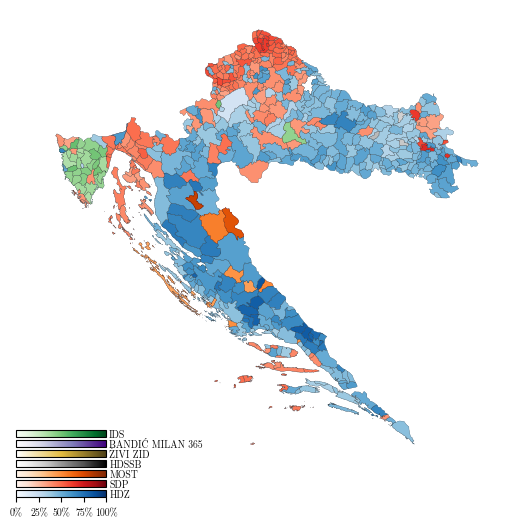

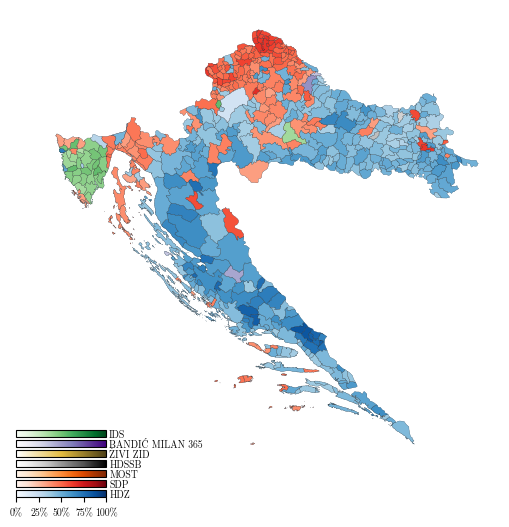

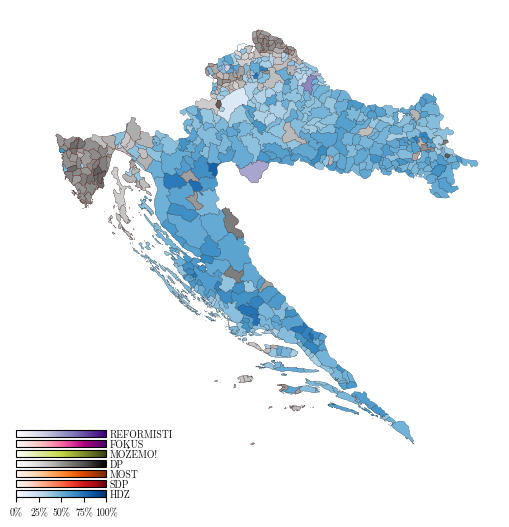

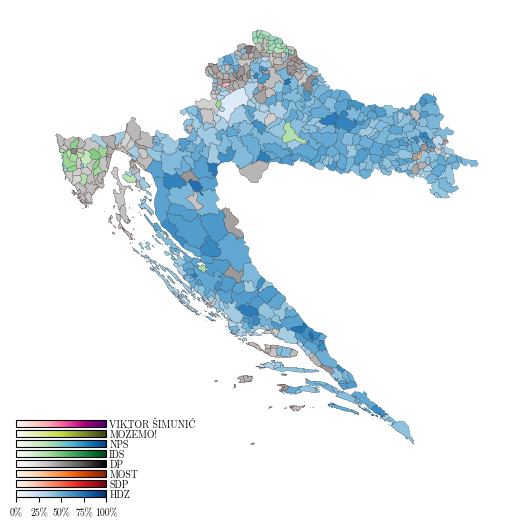

In [8]:
party_name = "None"
years = ["2015", "2016", "2020", "2024"]

for year in years:
    if year == "2015":
        all_city_winner_dict = data_import_and_process(party_name, year)
        map_plot(party_name, all_city_winner_dict, year, party_name, color_maps_2015, party_names_2015)
    elif year == "2016":
        all_city_winner_dict = data_import_and_process(party_name, year)
        map_plot(party_name, all_city_winner_dict, year, party_name, color_maps_2016, party_names_2016)
    elif year == "2020":
        all_city_winner_dict = data_import_and_process(party_name, year)
        map_plot(party_name, all_city_winner_dict, year, party_name, color_maps_2020, party_names_2020)
    elif year == "2024":
        all_city_winner_dict = data_import_and_process(party_name, year)
        map_plot(party_name, all_city_winner_dict, year, party_name, color_maps_2024, party_names_2024)